In [179]:
import os
import json
import pandas as pd
import pandas_profiling
import numpy as np
from scipy import stats
from scipy.odr import Model, Data, ODR
import statsmodels.api as sm
from patsy import dmatrices
from matplotlib import pyplot as plt
import rpy2
import statsmodels.api as smapi
from statsmodels.formula.api import ols
import statsmodels.graphics as smgraphics

In [116]:
%matplotlib inline

# Statistical analysis of feature computations results


## Data importation and manipulation

In [117]:
def get_path_to_all_files(folder_name):
    """Recursively get all filepaths from a directory tree."""

    filepaths = []
    for dirname, dirnames, filenames in os.walk(folder_name):
        for filename in filenames:
            if '.DS_Store' not in filename:
                filepaths.append(os.path.join(dirname, filename))

    return filepaths

### Data importation


In [118]:
results_folder = "/Users/Antonin/Documents/VUB/semester 4/thesis/validation study/data/results/feature_data"

In [119]:
files = get_path_to_all_files(results_folder)

#### Force plate feature data

In [120]:
fp_files = [file for file in files if "FP" in file]
fp_files[1:5]

['/Users/Antonin/Documents/VUB/semester 4/thesis/validation study/data/results/feature_data/Repro2/FP/1_3_cop_features.json',
 '/Users/Antonin/Documents/VUB/semester 4/thesis/validation study/data/results/feature_data/Repro2/FP/2_3_cop_features.json',
 '/Users/Antonin/Documents/VUB/semester 4/thesis/validation study/data/results/feature_data/Repro2/FP/3_3_cop_features.json',
 '/Users/Antonin/Documents/VUB/semester 4/thesis/validation study/data/results/feature_data/Repro2/FP/4_3_cop_features.json']

#### Wii Balance Board feature data


In [121]:
wbb_files = [file for file in files if "FP" not in file]
wbb_files[1:5]

['/Users/Antonin/Documents/VUB/semester 4/thesis/validation study/data/results/feature_data/Repro2/BB/1_3_cop_features.json',
 '/Users/Antonin/Documents/VUB/semester 4/thesis/validation study/data/results/feature_data/Repro2/BB/2_3_cop_features.json',
 '/Users/Antonin/Documents/VUB/semester 4/thesis/validation study/data/results/feature_data/Repro2/BB/3_3_cop_features.json',
 '/Users/Antonin/Documents/VUB/semester 4/thesis/validation study/data/results/feature_data/Repro2/BB/4_3_cop_features.json']

In [122]:
wbb_files_modified = [filename.replace("BB","FP") for filename in wbb_files]
fp_files_modified = [filename.replace("FP","BB") for filename in fp_files]

In [123]:
fp_files_curated = [file for file in fp_files if file in wbb_files_modified]
wbb_files_curated = [file for file in wbb_files if file in fp_files_modified]

In [124]:
print(fp_files_curated[1])
print(wbb_files_curated[1])
len(fp_files_curated)

/Users/Antonin/Documents/VUB/semester 4/thesis/validation study/data/results/feature_data/Repro2/FP/1_3_cop_features.json
/Users/Antonin/Documents/VUB/semester 4/thesis/validation study/data/results/feature_data/Repro2/BB/1_3_cop_features.json


72

In [125]:
identical_order_test = [i for i, j in zip(fp_files_curated, wbb_files_curated) if i == j.replace("BB","FP")]

In [126]:
if len(identical_order_test) == len(fp_files_curated):
    print("hello")

hello


###  Data manipulation

In [127]:
def create_index(df):
    arrays = [df["device"].values, df["subject"].values, 
             df["trial"].values, df["balance board"].values]
    tuples = list(zip(*arrays))
    return pd.MultiIndex.from_tuples(tuples, names=['device', 'subject','trial','balance board'])
    

In [128]:
def create_and_merge_dataframes(files):
    time_frames = []
    frequency_frames = []
    for filepath in files:
        with open(filepath) as json_data:
            features = json.load(json_data)     
            time_features = features["time_features"]
            frequency_features = features["frequency_features"]
            
            for dic in (time_features,frequency_features):
                dic["device"] = features["device"]
                dic["subject"] = features["subject"]
                dic["trial"] = features["trial"]
                dic["balance board"] = features["balance board"]

        time_frames.append(pd.DataFrame(time_features, index=[0]))
        frequency_frames.append(pd.DataFrame(frequency_features,index=[0]))
    
    time_features_df = pd.concat(time_frames, axis=0)    
    frequency_features_df = pd.concat(frequency_frames, axis=0)

    df1 = time_features_df.reset_index().drop(['device', 'subject','trial','balance board'], 1)
    df1.index = create_index(time_features_df)
    df1.drop('index', 1, inplace=True)
    df1.sort_index(inplace=True)
    
    df2 = frequency_features_df.reset_index().drop(['device', 'subject','trial','balance board'], 1)
    df2.index = create_index(frequency_features_df)
    df2.drop('index', 1, inplace=True)
    df2.sort_index(inplace=True)
    
    return (df1,df2)

####  WBB  features results merging

In [129]:
wbb_time, wbb_freq = create_and_merge_dataframes(wbb_files)

In [130]:
wbb_time.head()

Mean distance  Mean distance-ML  \
device subject trial balance board                                    
BB     1       1     1                   2.436242          0.789671   
                     2                   1.274733          0.630342   
                     3                   1.836121          0.630083   
                     4                   1.808499          0.523102   
               2     1                   2.833346          0.508445   

                                    Mean distance-AP  Rms distance  \
device subject trial balance board                                   
BB     1       1     1                      2.167427      2.719947   
                     2                      0.970876      1.496500   
                     3                      1.573749      2.084419   
                     4                      1.659966      2.150159   
               2     1                      2.722626      3.188031   

                                    Rms distance-ML  Rms distance-AP  \
device subject trial balance board                                     
BB     1       1     1                     0.973870         2.539624   
                     2                     0.809443         1.258696   
                     3                     0.798380         1.925459   
                     4                     0.622238         2.058155   
               2     1                     0.602140         3.130650   

                                       Range  Range-ML   Range-AP  \
device subject trial balance board                                  
BB     1       1     1              6.061932  4.318333  11.871667   
                     2              4.309944  4.411667   6.492500   
                     3              6.020228  2.996667  10.325833   
                     4              6.613891  3.055000   9.677500   
               2     1              5.412446  2.830000  11.775000   

                                    Mean velocity          ...           \
device subject trial balance board                         ...            
BB     1       1     1                   3.349532          ...            
                     2                   2.581552          ...            
                     3                   3.076954          ...            
                     4                   3.169031          ...            
               2     1                   2.918244          ...            

                                    Mean velocity-AP  Sway displacement  \
device subject trial balance board                                        
BB     1       1     1                      2.394042        4872.483986   
                     2                      1.993333        2549.465822   
                     3                      2.689792        3672.241351   
                     4                      2.525708        3616.997207   
               2     1                      2.190500        5666.692153   

                                    95% confidence circle area  \
device subject trial balance board                               
BB     1       1     1                               61.537505   
                     2                               20.658317   
                     3                               37.591382   
                     4                               43.511904   
               2     1                               86.173353   

                                    95% confidence elipse area  \
device subject trial balance board                               
BB     1       1     1                               76.148445   
                     2                               23.324055   
                     3                               46.144734   
                     4                               43.366000   
               2     1                               97.278695   

                                    Mean frequency  Mean frequency-ML  \
device 

In [131]:
wbb_freq.head()

Total power-RD  Total power-ML  \
device subject trial balance board                                   
BB     1       1     1                    0.939057        0.504764   
                     2                    0.411038        0.362403   
                     3                    0.764703        0.278623   
                     4                    1.000459        0.228923   
               2     1                    1.228499        0.211459   

                                    Total power-AP  Peak frequency-RD  \
device subject trial balance board                                      
BB     1       1     1                    2.596101               0.25   
                     2                    1.011728               0.15   
                     3                    2.239847               0.15   
                     4                    2.494564               0.20   
               2     1                    3.881972               0.15   

                                    Peak frequency-ML  Peak frequency-AP  \
device subject trial balance board                                         
BB     1       1     1                           0.15               0.20   
                     2                           0.15               0.20   
                     3                           0.15               0.15   
                     4                           0.15               0.15   
               2     1                           0.15               0.15   

                                    50% power frequency-RD  \
device subject trial balance board                           
BB     1       1     1                                0.30   
                     2                                0.35   
                     3                                0.40   
                     4                                0.40   
               2     1                                0.25   

                                    50% power frequency-ML  \
device subject trial balance board                           
BB     1       1     1                                 0.3   
                     2                                 0.3   
                     3                                 0.2   
                     4                                 0.4   
               2     1                                 0.4   

                                    50% power frequency-AP  \
device subject trial balance board                           
BB     1       1     1                                 0.2   
                     2                                 0.3   
                     3                                 0.3   
                     4                                 0.3   
               2     1                                 0.2   

                                    80% power frequency-RD  \
device subject trial balance board                           
BB     1       1     1                                0.55   
                     2                                0.60   
                     3                                0.70   
                     4                                0.70   
               2     1                                0.45   

                                             ...             \
device subject trial balance board           ...              
BB     1       1     1                       ...              
                     2                       ...              
                     3                       ...              
                     4                       ...              
               2     1                       ...              

                                    80% power frequency-AP  \
device subject trial balance board                           
BB     1       1     1                                0.35   
                     2                                0.50   
                     3                                0.50   
        

#### FP  features results merging

In [132]:
fp_time,fp_freq = create_and_merge_dataframes(fp_files)

In [133]:
fp_time.head()

Mean distance  Mean distance-ML  \
device subject trial balance board                                    
FP     1       1     1                   3.819077          1.360315   
                     2                   2.294876          1.114177   
                     3                   3.236124          1.189109   
                     4                   2.982131          1.053451   
               2     1                   4.340153          0.927010   

                                    Mean distance-AP  Rms distance  \
device subject trial balance board                                   
FP     1       1     1                      3.295534      4.278385   
                     2                      1.737055      2.723611   
                     3                      2.754684      3.760537   
                     4                      2.619491      3.530979   
               2     1                      4.116730      4.884328   

                                    Rms distance-ML  Rms distance-AP  \
device subject trial balance board                                     
FP     1       1     1                     1.715556         3.919368   
                     2                     1.476088         2.288934   
                     3                     1.494396         3.450858   
                     4                     1.288457         3.287505   
               2     1                     1.159843         4.744621   

                                        Range  Range-ML   Range-AP  \
device subject trial balance board                                   
FP     1       1     1              11.716975  8.631975  19.650951   
                     2               9.036426  9.329073  14.513495   
                     3              10.164637  6.913138  18.691529   
                     4              10.449709  7.075276  15.755762   
               2     1               9.545170  6.061715  18.768235   

                                    Mean velocity          ...           \
device subject trial balance board                         ...            
FP     1       1     1                   9.592458          ...            
                     2                   8.351615          ...            
                     3                   9.429291          ...            
                     4                  10.304795          ...            
               2     1                   8.739792          ...            

                                    Mean velocity-AP  Sway displacement  \
device subject trial balance board                                        
FP     1       1     1                      6.516153        7638.154522   
                     2                      6.557250        4589.752451   
                     3                      7.815196        6472.247463   
                     4                      7.581913        5964.261230   
               2     1                      5.970290        8680.306459   

                                    95% confidence circle area  \
device subject trial balance board                               
FP     1       1     1                              153.564765   
                     2                               69.628781   
                     3                              128.162338   
                     4                              116.604333   
               2     1                              202.357690   

                                    95% confidence elipse area  \
device subject trial balance board                               
FP     1       1     1                              203.999603   
                     2                               87.646163   
                     3                              160.734617   
                     4                              131.444125   
               2     1                              242.582514   

                                    Mean frequency  Mean frequency-ML  \


In [134]:
fp_freq.head()

Total power-RD  Total power-ML  \
device subject trial balance board                                   
FP     1       1     1                    2.575226        1.936594   
                     2                    1.532867        1.233130   
                     3                    2.930188        1.218301   
                     4                    2.780645        1.213123   
               2     1                    3.309190        0.997884   

                                    Total power-AP  Peak frequency-RD  \
device subject trial balance board                                      
FP     1       1     1                    6.578097               0.25   
                     2                    3.551557               0.15   
                     3                    7.568572               0.15   
                     4                    6.846775               0.20   
               2     1                    9.613204               0.15   

                                    Peak frequency-ML  Peak frequency-AP  \
device subject trial balance board                                         
FP     1       1     1                           0.20               0.20   
                     2                           0.15               0.25   
                     3                           0.15               0.15   
                     4                           0.15               0.15   
               2     1                           0.15               0.20   

                                    50% power frequency-RD  \
device subject trial balance board                           
FP     1       1     1                                0.40   
                     2                                0.65   
                     3                                0.45   
                     4                                0.50   
               2     1                                0.35   

                                    50% power frequency-ML  \
device subject trial balance board                           
FP     1       1     1                                0.55   
                     2                                0.30   
                     3                                0.35   
                     4                                0.65   
               2     1                                0.70   

                                    50% power frequency-AP  \
device subject trial balance board                           
FP     1       1     1                                0.25   
                     2                                0.40   
                     3                                0.30   
                     4                                0.35   
               2     1                                0.25   

                                    80% power frequency-RD  \
device subject trial balance board                           
FP     1       1     1                                0.85   
                     2                                1.30   
                     3                                0.80   
                     4                                1.00   
               2     1                                0.70   

                                             ...             \
device subject trial balance board           ...              
FP     1       1     1                       ...              
                     2                       ...              
                     3                       ...              
                     4                       ...              
               2     1                       ...              

                                    80% power frequency-AP  \
device subject trial balance board                           
FP     1       1     1                                0.45   
                     2                                1.00   
                     3                                0.60   
        

#### Outlier detection study !!!
 

In [135]:
def get_outlier_identity(data, feature_name, balance_board_number):
    data = data.loc[data.index.get_level_values('balance board') == balance_board_number]
    outlier_values = data[data[feature_name]==data[feature_name].max()]

    return outlier_values.index

In [136]:
fp_outlier_index_1 = get_outlier_identity(fp_time,"Range","1")
fp_time.loc[fp_outlier_index_1]

,,,,Mean distance,Mean distance-ML,Mean distance-AP,Rms distance,Rms distance-ML,Rms distance-AP,Range,Range-ML,Range-AP,Mean velocity,...,Mean velocity-AP,Sway displacement,95% confidence circle area,95% confidence elipse area,Mean frequency,Mean frequency-ML,Mean frequency-AP,Sway area,Fractal dimension-CC,Fractal dimension-CE
device,subject,trial,balance board,,,,,,,,,,,,,,,,,,,,,
FP,3,3,1,7.939303,3.817471,6.076021,11.224239,7.648624,8.214748,49.095518,60.353221,53.080534,26.781666,...,21.206932,15878.605765,1384.256086,1605.264574,0.536878,0.568556,0.616998,98.712195,1.503731,1.482017


In [137]:
wbb_outlier_index_1 = get_outlier_identity(wbb_time,"Range","1")
wbb_time.loc[wbb_outlier_index_1]

,,,,Mean distance,Mean distance-ML,Mean distance-AP,Rms distance,Rms distance-ML,Rms distance-AP,Range,Range-ML,Range-AP,Mean velocity,...,Mean velocity-AP,Sway displacement,95% confidence circle area,95% confidence elipse area,Mean frequency,Mean frequency-ML,Mean frequency-AP,Sway area,Fractal dimension-CC,Fractal dimension-CE
device,subject,trial,balance board,,,,,,,,,,,,,,,,,,,,,
BB,3,3,1,3.96703,1.289546,3.560172,5.02676,1.951189,4.632621,16.461776,16.899167,26.349167,7.689966,...,6.5005,7934.059606,257.049748,287.552168,0.308517,0.393364,0.322776,10.94821,1.391936,1.377789


In [138]:
fp_outlier_values_2 = get_outlier_identity(fp_time,"Range-AP", "2")
fp_time.loc[fp_outlier_values_2]

,,,,Mean distance,Mean distance-ML,Mean distance-AP,Rms distance,Rms distance-ML,Rms distance-AP,Range,Range-ML,Range-AP,Mean velocity,...,Mean velocity-AP,Sway displacement,95% confidence circle area,95% confidence elipse area,Mean frequency,Mean frequency-ML,Mean frequency-AP,Sway area,Fractal dimension-CC,Fractal dimension-CE
device,subject,trial,balance board,,,,,,,,,,,,,,,,,,,,,
FP,4,1,2,7.217866,3.203614,5.95133,12.346152,5.396082,11.104493,63.802909,41.729828,108.262877,36.714919,...,31.663785,14435.732089,1763.853055,1813.819564,0.809569,0.714449,0.940532,143.706968,1.563844,1.559363


In [139]:
wbb_outlier_values_2 = get_outlier_identity(wbb_time,"Range-AP", "2")
wbb_time.loc[wbb_outlier_values_2]

,,,,Mean distance,Mean distance-ML,Mean distance-AP,Rms distance,Rms distance-ML,Rms distance-AP,Range,Range-ML,Range-AP,Mean velocity,...,Mean velocity-AP,Sway displacement,95% confidence circle area,95% confidence elipse area,Mean frequency,Mean frequency-ML,Mean frequency-AP,Sway area,Fractal dimension-CC,Fractal dimension-CE
device,subject,trial,balance board,,,,,,,,,,,,,,,,,,,,,
BB,4,1,2,3.554435,1.699614,2.869411,5.33511,2.781461,4.552678,18.495845,15.951667,28.820833,8.461401,...,7.084125,7108.870633,320.426889,346.5678,0.378871,0.331025,0.436434,19.791885,1.388226,1.378354


In [140]:
fp_outlier_values_3 = get_outlier_identity(fp_time,"Range-AP", "3")
fp_time.loc[fp_outlier_values_3]

,,,,Mean distance,Mean distance-ML,Mean distance-AP,Rms distance,Rms distance-ML,Rms distance-AP,Range,Range-ML,Range-AP,Mean velocity,...,Mean velocity-AP,Sway displacement,95% confidence circle area,95% confidence elipse area,Mean frequency,Mean frequency-ML,Mean frequency-AP,Sway area,Fractal dimension-CC,Fractal dimension-CE
device,subject,trial,balance board,,,,,,,,,,,,,,,,,,,,,
FP,4,1,3,4.644699,1.772542,3.828248,6.488241,3.04133,5.731281,33.836308,27.514422,43.757352,14.358545,...,11.274306,9289.397161,459.741593,503.403568,0.492009,0.690413,0.520613,25.362009,1.482542,1.469539


In [141]:
wbb_outlier_values_3 = get_outlier_identity(wbb_time,"Range-AP", "3")
wbb_time.loc[wbb_outlier_values_3]

,,,,Mean distance,Mean distance-ML,Mean distance-AP,Rms distance,Rms distance-ML,Rms distance-AP,Range,Range-ML,Range-AP,Mean velocity,...,Mean velocity-AP,Sway displacement,95% confidence circle area,95% confidence elipse area,Mean frequency,Mean frequency-ML,Mean frequency-AP,Sway area,Fractal dimension-CC,Fractal dimension-CE
device,subject,trial,balance board,,,,,,,,,,,,,,,,,,,,,
BB,4,1,3,4.157213,1.260706,3.701934,5.549595,1.78861,5.253463,17.494294,11.61,31.998333,7.415149,...,5.955625,8314.426792,327.159982,333.401505,0.283882,0.452684,0.284396,12.597214,1.353039,1.350767


In [142]:
fp_outlier_values_4 = get_outlier_identity(fp_time,"Range", "4")
fp_time.loc[fp_outlier_values_4]

,,,,Mean distance,Mean distance-ML,Mean distance-AP,Rms distance,Rms distance-ML,Rms distance-AP,Range,Range-ML,Range-AP,Mean velocity,...,Mean velocity-AP,Sway displacement,95% confidence circle area,95% confidence elipse area,Mean frequency,Mean frequency-ML,Mean frequency-AP,Sway area,Fractal dimension-CC,Fractal dimension-CE
device,subject,trial,balance board,,,,,,,,,,,,,,,,,,,,,
FP,1,3,4,9.473749,0.890688,9.351169,10.759407,1.148549,10.697929,23.243723,7.562212,43.994009,9.634449,...,7.280181,18947.497593,1002.521546,1110.365579,0.161855,0.903261,0.137626,22.823096,1.28486,1.273859


In [143]:
wbb_outlier_values_4 = get_outlier_identity(wbb_time,"Range", "4")
wbb_time.loc[wbb_outlier_values_4]

,,,,Mean distance,Mean distance-ML,Mean distance-AP,Rms distance,Rms distance-ML,Rms distance-AP,Range,Range-ML,Range-AP,Mean velocity,...,Mean velocity-AP,Sway displacement,95% confidence circle area,95% confidence elipse area,Mean frequency,Mean frequency-ML,Mean frequency-AP,Sway area,Fractal dimension-CC,Fractal dimension-CE
device,subject,trial,balance board,,,,,,,,,,,,,,,,,,,,,
BB,1,3,4,6.199894,0.503513,6.146129,6.990086,0.637905,6.960918,12.833768,2.515833,26.0425,3.237613,...,2.76075,12399.788884,416.243696,462.632718,0.083111,0.38188,0.079405,3.894676,1.157483,1.148245


In [144]:
wbb_outlier_values_4 = get_outlier_identity(wbb_freq,"Frequency dispersion-AP", "1")
wbb_freq.loc[wbb_outlier_values_4]

,,,,Total power-RD,Total power-ML,Total power-AP,Peak frequency-RD,Peak frequency-ML,Peak frequency-AP,50% power frequency-RD,50% power frequency-ML,50% power frequency-AP,80% power frequency-RD,...,80% power frequency-AP,95% power frequency-RD,95% power frequency-ML,95% power frequency-AP,Centroidal frequency-RD,Centroidal frequency-ML,Centroidal frequency-AP,Frequency dispersion-RD,Frequency dispersion-ML,Frequency dispersion-AP
device,subject,trial,balance board,,,,,,,,,,,,,,,,,,,,,
BB,6,3,1,0.744599,0.13842,1.974193,0.25,0.15,0.15,0.4,0.3,0.25,1.15,...,0.6,2.7,1.1,1.5,1.126051,0.647971,0.743456,0.754487,0.758484,0.791433


#### Duplicates study 



TODO

## Statistical analysis

### General descriptive statistics HTML reports 

In [145]:
wbb_time.head()
wbb_time.index.get_level_values(3)
wbb_time_1 = wbb_time.loc[(wbb_time.index.get_level_values(3)=="1")]

In [146]:
outputfile = "/Users/Antonin/Documents/VUB/semester 4/thesis/validation study/notebooks/results/wbb_data_1_time_domain_report.html"
df_profile = pandas_profiling.ProfileReport(wbb_time_1, bins=50)
df_profile.to_file(outputfile=outputfile)

### Features mean value and standard deviation 

In [147]:
def compute_mean_and_stds(df1, df2):
    """Compute the mean and standard deviation values for each feature and each balance board."""

    wbb_and_fp_results = pd.concat([df1, df2], axis=0) 
    feature_mean_results= wbb_and_fp_results.groupby([wbb_and_fp_results.index.get_level_values(0),wbb_and_fp_results.index.get_level_values(3)]).mean().transpose().stack(0).unstack()
    feature_std_results= wbb_and_fp_results.groupby([wbb_and_fp_results.index.get_level_values(0),wbb_and_fp_results.index.get_level_values(3)]).std().transpose().stack(0).unstack()
    aggregated_results = (feature_mean_results, feature_std_results)
    
    return aggregated_results

In [148]:
time_mean_results, time_std_results = compute_mean_and_stds(wbb_time, fp_time)

In [149]:
time_mean_results.head()

balance board            1                   2                   3            \
device                  BB        FP        BB        FP        BB        FP   
Mean distance     2.502738  4.123373  2.601201  4.495291  2.275892  3.663500   
Mean distance-ML  0.700966  1.364943  0.852832  1.650562  0.763997  1.366960   
Mean distance-AP  2.265642  3.590121  2.286729  3.832221  1.988932  3.112241   
Rms distance      2.960851  4.994384  3.110349  5.485620  2.657452  4.310567   
Rms distance-ML   0.914703  1.962690  1.135989  2.264698  0.952100  1.765156   

balance board            4            
device                  BB        FP  
Mean distance     2.456814  3.961751  
Mean distance-ML  0.770873  1.374759  
Mean distance-AP  2.178660  3.418662  
Rms distance      2.808898  4.549620  
Rms distance-ML   0.937892  1.737703

### Spearman correlation

In [150]:
def compute_spearman_correlation(df1, df2):
    
    wbb_numbers = ["1", "2", "3", "4"]
    dfs_1 = [df1.loc[(df1.index.get_level_values(3) == number)] for number in wbb_numbers]
    dfs_1_mean = [df.groupby([df.index.get_level_values(0),df.index.get_level_values(1),\
                                  df.index.get_level_values(3)]).mean() for df in dfs_1]

    dfs_2 = [df2.loc[(df2.index.get_level_values(3) == number)] for number in wbb_numbers]
    dfs_2_mean = [df.groupby([df.index.get_level_values(0),df.index.get_level_values(1),\
                                  df.index.get_level_values(3)]).mean() for df in dfs_2]
    
    result_dict = {key:{} for key in df1.columns}
    
    for (df1, df2, number) in zip(dfs_1_mean, dfs_2_mean, wbb_numbers):
        # Loop over each feature
        for column in df1.columns:
            x = df1[column]
            y = df2[column]

            # Compute the spearman coefficient(rho) and the corresponding p-value
            rho, p_value = stats.spearmanr(x, y, nan_policy="propagate")

            # Store the results
            result_dict[column][number] = {}
            result_dict[column][number]["p-value"] = p_value
            result_dict[column][number]["rho"] = rho
            
    result_dict_collapsed = {(outer_k, inner_k): inner_v for outer_k in result_dict
               for inner_k, inner_v in result_dict[outer_k].items()}

    aggregated_results = pd.DataFrame.from_dict(result_dict_collapsed).transpose()
    aggregated_results = aggregated_results.unstack().stack(0).unstack()

    return aggregated_results

In [151]:
time_spearman_results = compute_spearman_correlation(wbb_time, fp_time)

In [152]:
time_spearman_results.head()

1                   2                   3  \
                             p-value       rho   p-value       rho   p-value   
95% confidence circle area  0.004805  0.942857  0.004805  0.942857  0.004805   
95% confidence elipse area  0.004805  0.942857  0.000000  1.000000  0.041563   
Fractal dimension-CC        0.018845  0.885714  0.041563  0.828571  0.072397   
Fractal dimension-CE        0.072397  0.771429  0.041563  0.828571  0.208000   
Mean distance               0.004805  0.942857  0.000000  1.000000  0.041563   

                                             4            
                                 rho   p-value       rho  
95% confidence circle area  0.942857  0.000000  1.000000  
95% confidence elipse area  0.828571  0.041563  0.828571  
Fractal dimension-CC        0.771429  0.208000  0.600000  
Fractal dimension-CE        0.600000  0.396501  0.428571  
Mean distance               0.828571  0.004805  0.942857

In [153]:
wbb_time.columns

Index(['Mean distance', 'Mean distance-ML', 'Mean distance-AP', 'Rms distance',
       'Rms distance-ML', 'Rms distance-AP', 'Range', 'Range-ML', 'Range-AP',
       'Mean velocity', 'Mean velocity-ML', 'Mean velocity-AP',
       'Sway displacement', '95% confidence circle area',
       '95% confidence elipse area', 'Mean frequency', 'Mean frequency-ML',
       'Mean frequency-AP', 'Sway area', 'Fractal dimension-CC',
       'Fractal dimension-CE'],
      dtype='object')

### Pearson's correlation coefficient and regression lines equations 


In [154]:
fp_time_cut = fp_time[:wbb_time.shape[0]]

#### Ordinary least square regression (OLS)

In [194]:
def plot_correlation(df1,df2,name="time_domain"):
    columns = df1.columns
    fig, axs = plt.subplots(3,7,figsize=(30,15),facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5)
    #axs[-1, -1].axis('off')
    for ax, column in zip(axs.ravel(), columns):
        x = df2[column]
        y = df1[column]
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        ax.plot(x, y, '.', label='original data')
        ax.plot(x, intercept + slope*x, 'black', label='fitted line', linewidth=0.3)
        ax.set_xlabel('Force plate')

        ax.set_ylabel('Balance Board')
        ax.set_title(column, weight = 600)
        r_squared = round(r_value**2,4)
        ax.text(0.8, 0.4, "p-value = {}".format(round(p_value,4)), fontsize=9, horizontalalignment='center',
                verticalalignment='center', transform=ax.transAxes)
        ax.text(0.8, 0.3, "R\u00b2={}".format(r_squared), fontsize=9, horizontalalignment='center',
                verticalalignment='center', transform=ax.transAxes)
        ax.text(0.8, 0.2, "Slope = {}".format(round(slope,4)), fontsize=9, horizontalalignment='center',
                verticalalignment='center', transform=ax.transAxes)
        ax.text(0.8, 0.1, "Intercept = {}".format(round(intercept,4)), fontsize=9, horizontalalignment='center',
                verticalalignment='center', transform=ax.transAxes)
        #ax.legend()
    plt.tight_layout()
    plt.savefig("results/{}_correlation_plots.png".format(name), bbox_inches='tight')


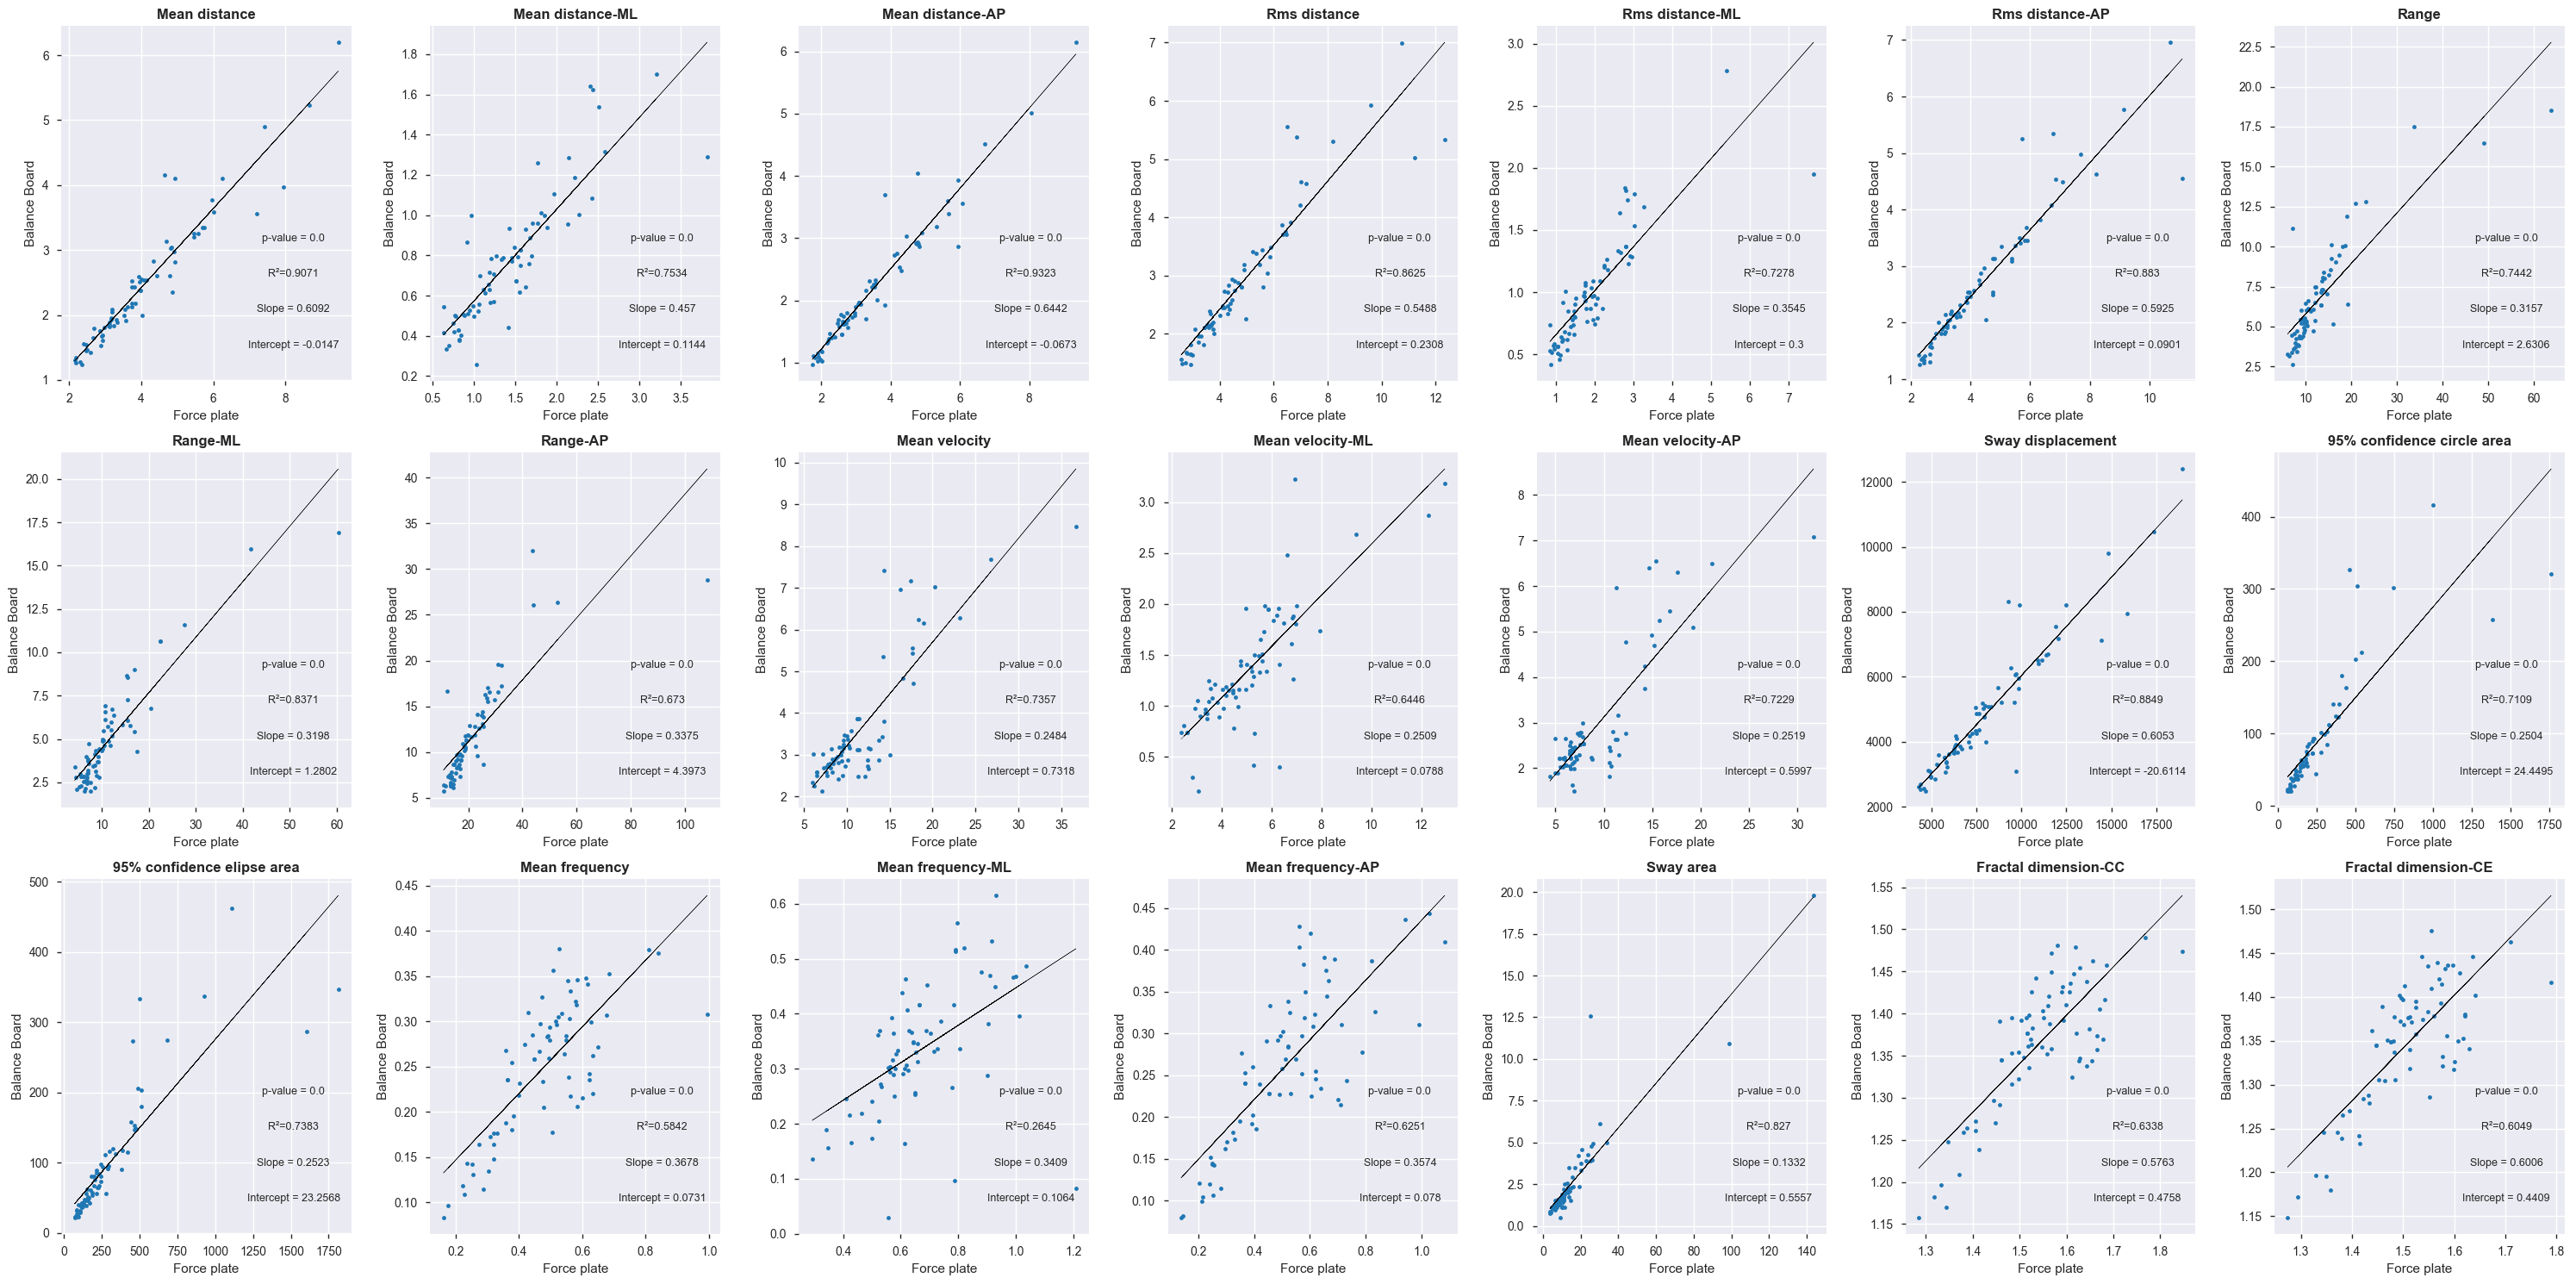

In [195]:
plot_correlation(wbb_time, fp_time_cut)

##### Use a diffrent library (statsmodels) FOR OLS

In [157]:
def plot_correlation_2(df1,df2):
    columns = df1.columns
    fig, axs = plt.subplots(6,3,figsize=(20,30),facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5)
    axs[-1, -1].axis('off')
    for ax, column in zip(axs.ravel(), columns):
        x = df1[column]
        y = df2[column]
        regression = ols("data ~ x", data=dict(data=y, x=x)).fit(covtype="scale")
        
        # Find outliers #
        test = regression.outlier_test()
        outliers = ((x[i],y[i]) for i,t in enumerate(test["unadj_p"]) if t < 0.5)
        #print ('Outliers: ', list(outliers))
        
        smgraphics.regressionplots.plot_fit(regression, 1, ax=ax)
        # Add line
        smgraphics.regressionplots.abline_plot(model_results=regression, ax=ax)
        
        #ax.plot(x, y, '.', label='original data')
        ax.set_xlabel('Balance Board')
        ax.set_ylabel('Force plate')
        ax.set_title(column, weight = 600)

        #ax.legend()
    #plt.savefig("results/{}_correlation_plots.png".format(name), bbox_inches='tight')



In [158]:
#plot_correlation_2(wbb_time, fp_time_cut)

#### Total least square regression (ODR)

In [189]:
def linear(p, x):
    """Basic linear regression 'model' for use with ODR"""
    return (p[0] * x) + p[1]


In [190]:
def orthoregress(x, y):
    """
    Performs an Orthogonal Distance Regression on the given data,
    using the same interface as the standard scipy.stats.linregress function.
    Uses standard ordinary least squares to estimate the starting parameters
    then uses the scipy.odr interface to the ODRPACK Fortran code to do the
    orthogonal distance calculations.
    """
    linreg = stats.linregress(x, y)
    mod = Model(linear)
    dat = Data(x, y)
    od = ODR(dat, mod, beta0=linreg[0:2])
    out = od.run()
    #out.pprint()
    slope, intercept = out.beta[0], out.beta[1]

    return slope, intercept

In [191]:
test =  orthoregress(wbb_time[wbb_time.columns[0]], fp_time_cut[fp_time_cut.columns[0]])
test

(1.5963823927648253, 0.1352171329067854)

In [200]:
def plot_correlation_3(df1,df2,name="time_domain"):
    columns = df1.columns
    fig, axs = plt.subplots(3,7,figsize=(30,15),facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5)
    #axs[-1, -1].axis('off')
    for ax, column in zip(axs.ravel(), columns):
        x = df2[column]
        y = df1[column]
        slope, intercept = orthoregress(x, y)
        ax.plot(x, y, '.', label='original data')
        ax.plot(x, intercept + slope*x, 'black', label='fitted line', linewidth=0.3)
        ax.set_xlabel('Force plate')
        ax.set_ylabel('Balance Board')
        ax.set_title(column, weight = 600)
        #r_squared = round(r_value**2,4)
        ax.text(0.8, 0.2, "Slope = {}".format(round(slope,4)), fontsize=9, horizontalalignment='center',
                verticalalignment='center', transform=ax.transAxes)
        ax.text(0.8, 0.1, "Intercept = {}".format(round(intercept,4)), fontsize=9, horizontalalignment='center',
                verticalalignment='center', transform=ax.transAxes)
        #ax.legend()
    plt.tight_layout()
    plt.savefig("results/{}_ODR_correlation_plots.png".format(name), bbox_inches='tight')



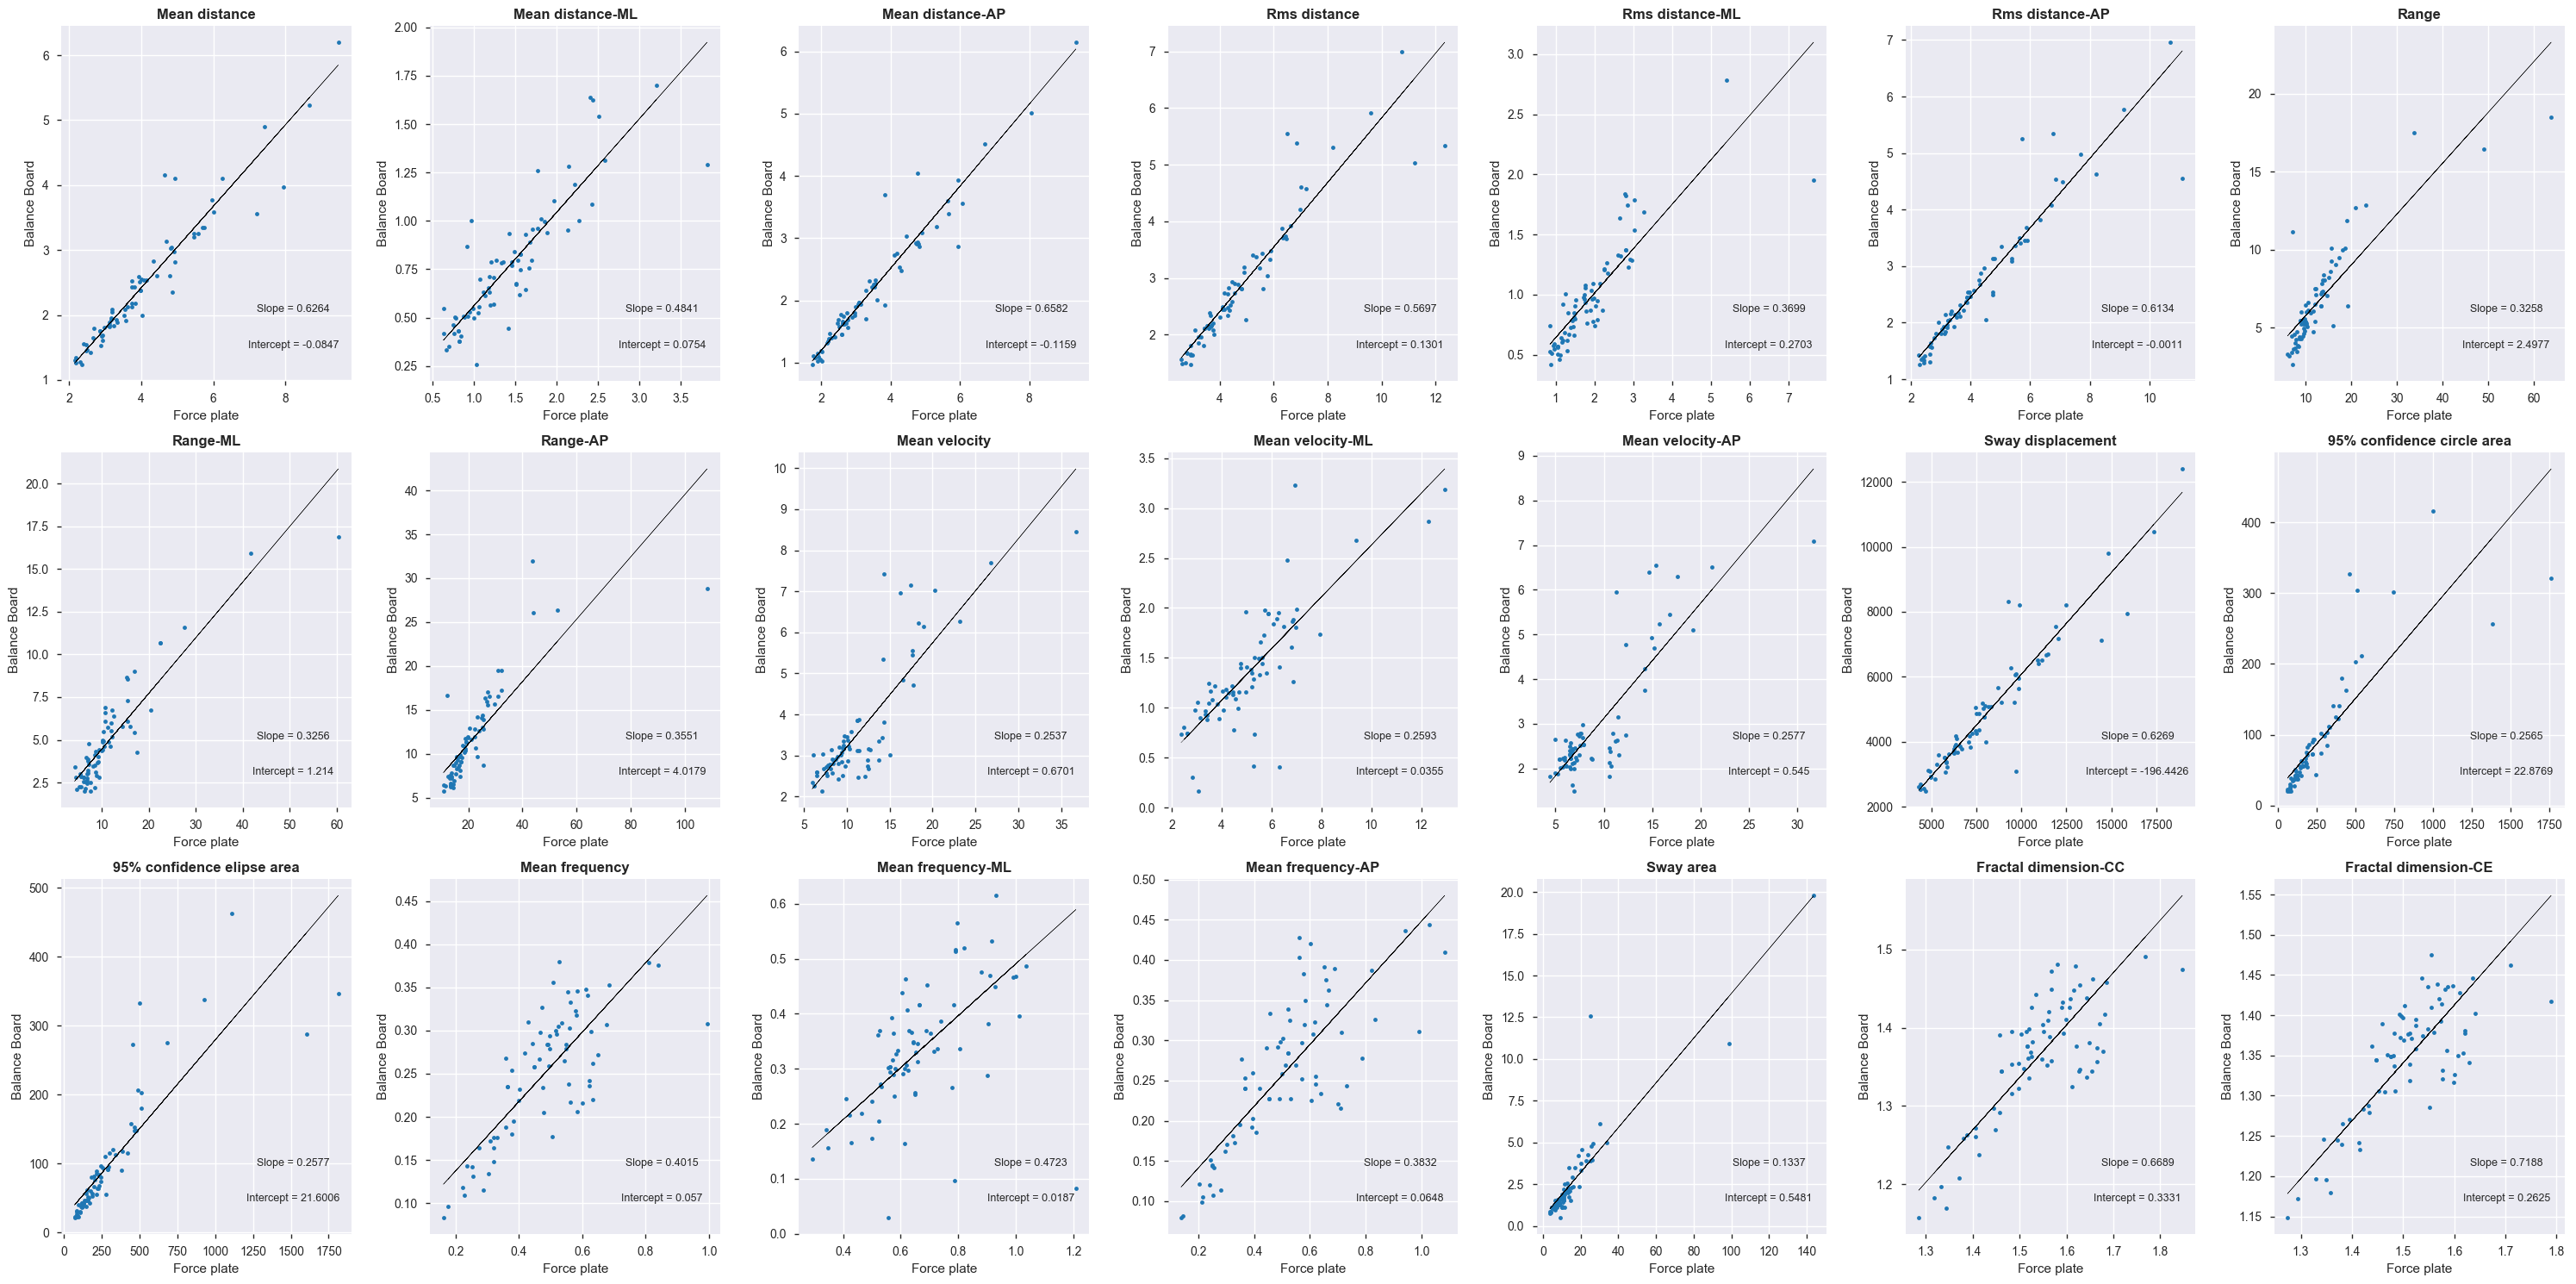

In [201]:
plot_correlation_3(wbb_time, fp_time_cut)

### Bland and Altman plots + LOA (limit of agreement)

In [159]:
def bland_altman_plot(df1, df2, name="time_domain"):
    columns = df1.columns
    fig, axs = plt.subplots(7,3,figsize=(20,30),facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5)
    df1= df1.reorder_levels(['balance board','device','subject','trial']).sort_index()
    df2= df2.reorder_levels(['balance board','device','subject','trial']).sort_index()

    for ax, column in zip(axs.ravel(), columns):
        x = df1[column].values
        y = df2[column].values
        data1 = np.asarray(x)
        data2 = np.asarray(y)
        #mean = np.mean([x, y], axis=0)
        trials = [trial for trial in range(len(data1))]
        diff = x - y 
        md = np.mean(diff)               
        sd = np.std(diff, axis=0)

        ax.scatter(trials, diff, marker='.',s=60, color = "gray",  )
        trials_limits = [x * 18 + 0.5 for x in range(1, 4)]
        for limit in trials_limits:
            ax.axvline(limit,color='black', linestyle='--', linewidth=0.5)

        ax.axhline(md,color='tomato', linestyle='--')
        ax.axhline(md + 2*sd, color='teal', linestyle='--', linewidth=0.5)
        ax.axhline(md - 2*sd, color='teal', linestyle='--', linewidth=0.5)
        ax.set_xlabel('Trials')
        ax.set_ylabel('Difference')
        ax.set_title(column, weight = 600)
        
        #ax.legend()
    plt.savefig("results/{}_bland_altman_plots.png".format(name), bbox_inches='tight')

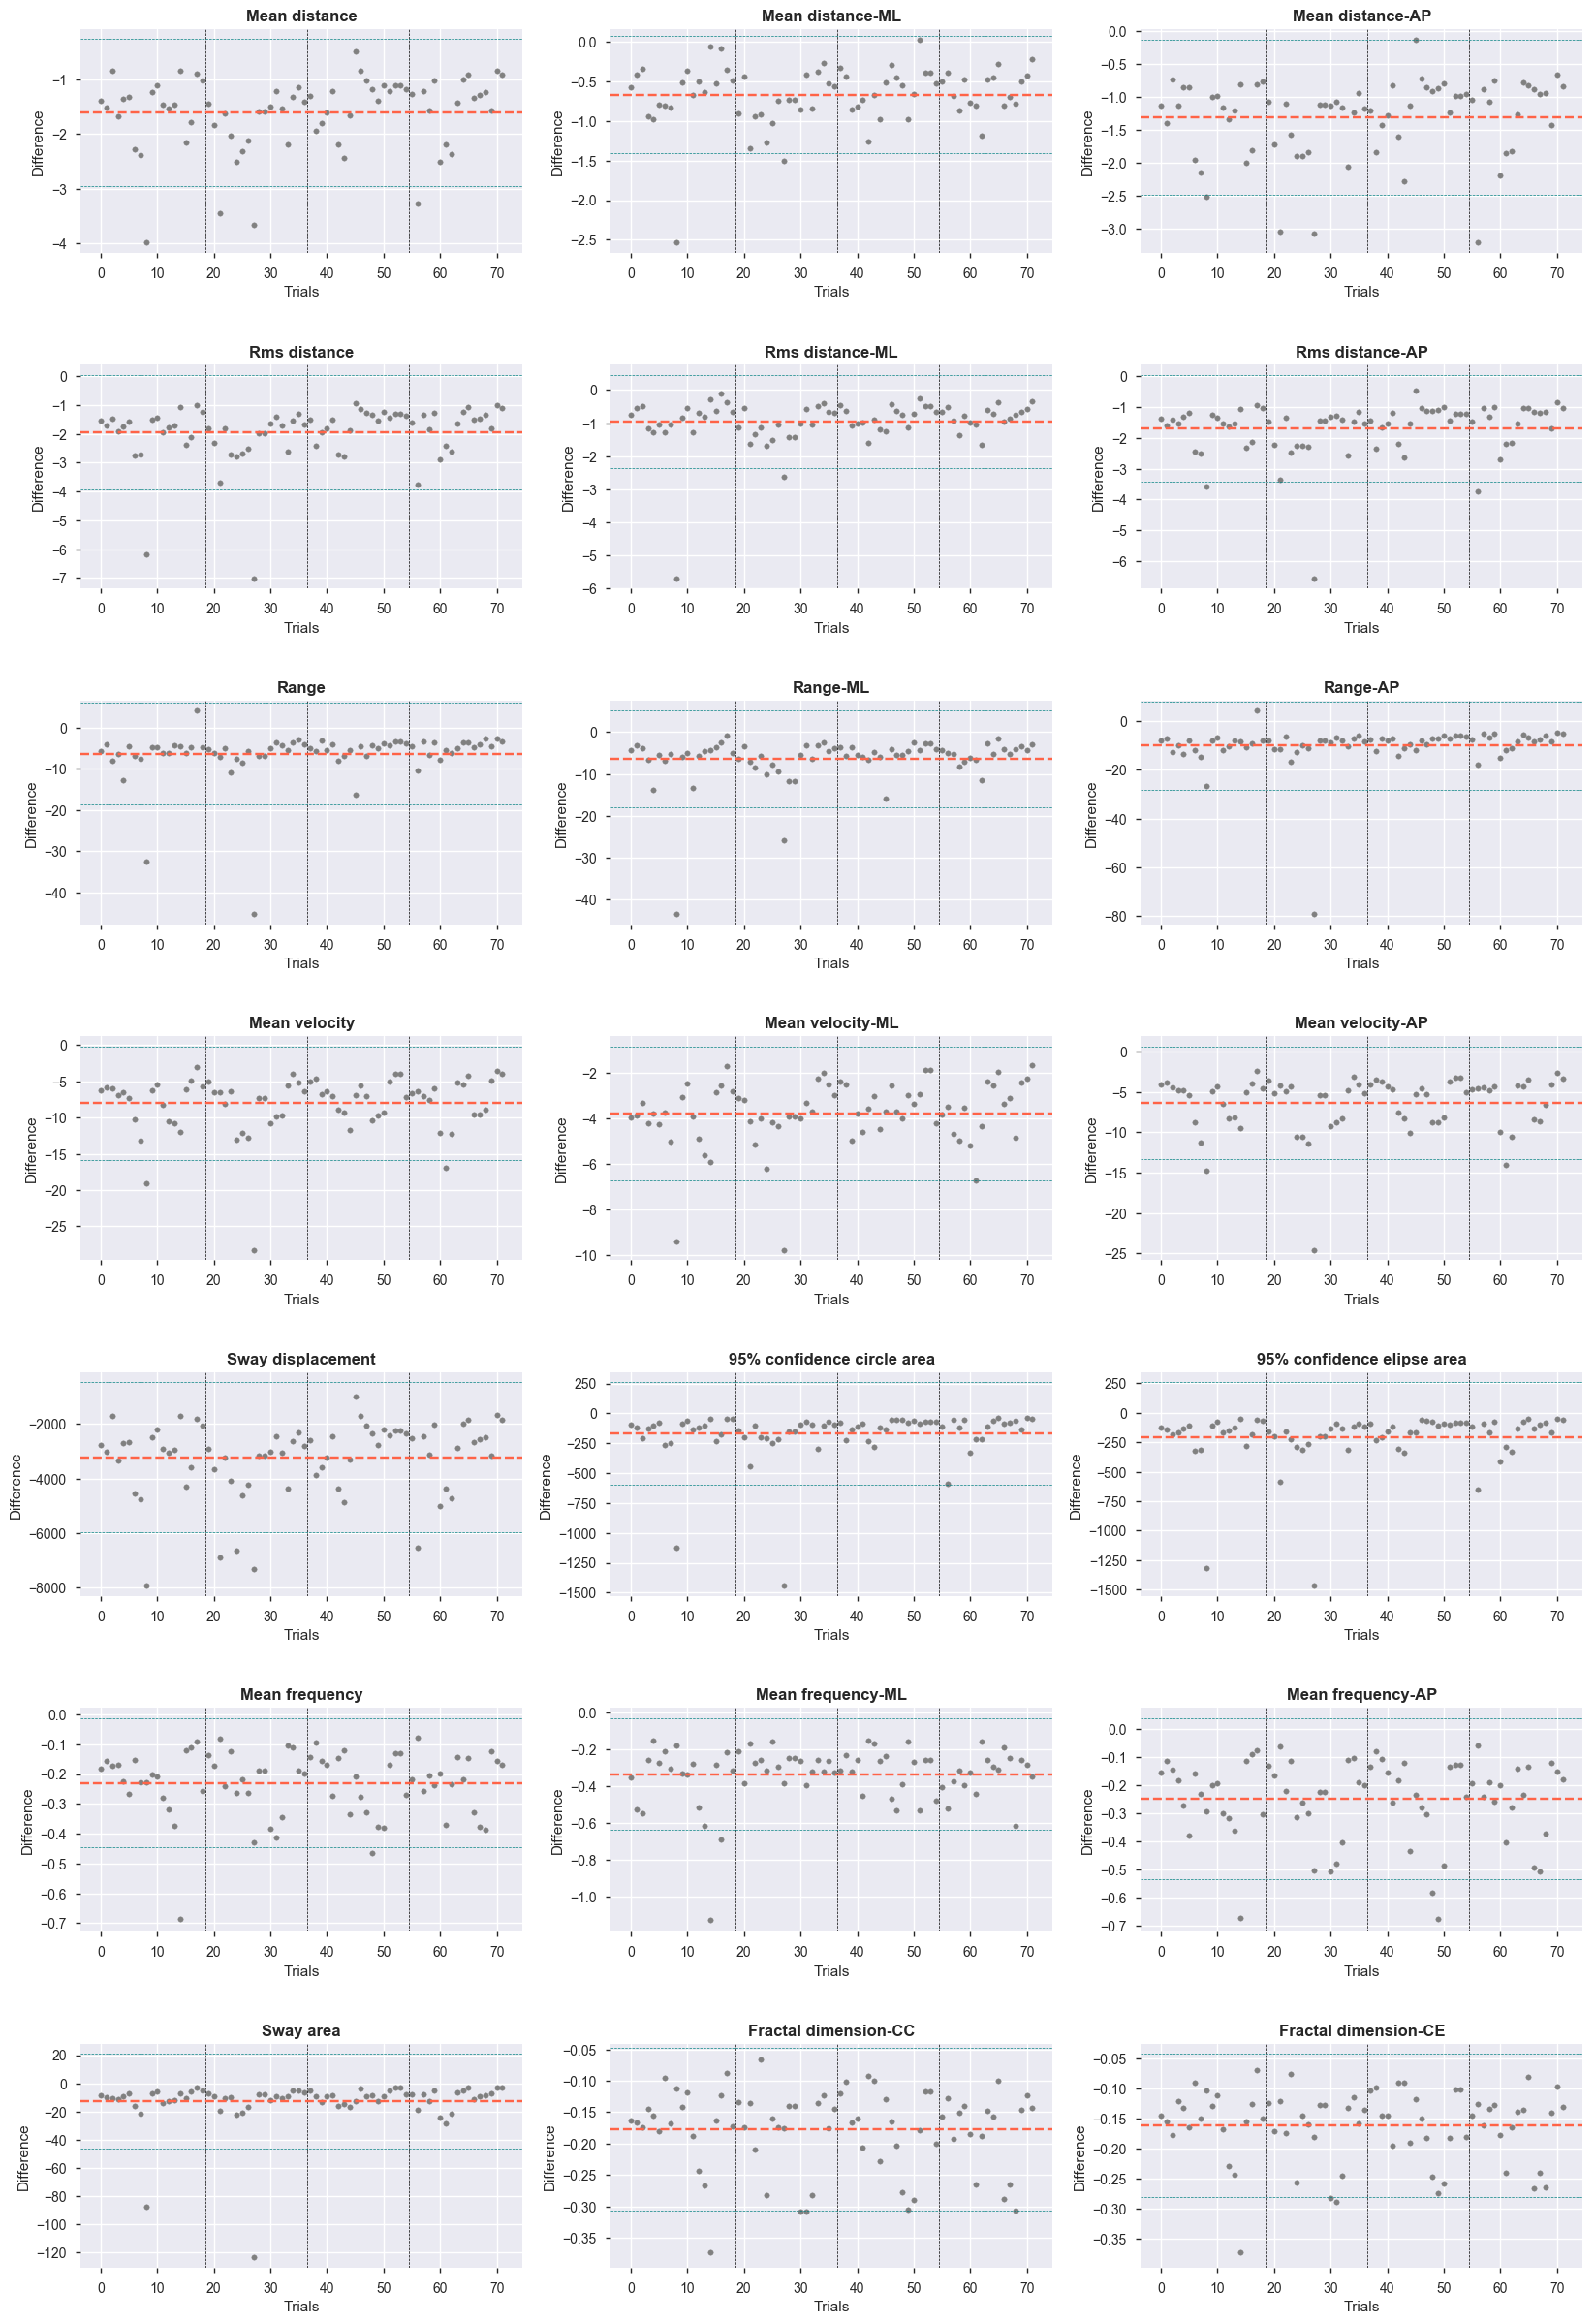

In [160]:
bland_altman_plot(wbb_time,fp_time)

###  Intraclass correlation coefficient (ICC) 



In [161]:
from rpy2.robjects import DataFrame, FloatVector, pandas2ri
from rpy2.robjects.packages import importr

In [162]:
rpy2.__version__

'2.9.5'

In [163]:
def compute_ICC(df1):
    """
    Compute the two-way mixed ICC.

    References
    ----------
    .. [1] R library used for the ICC implementation: http://www.personality-project.org/r/html/ICC.html

    Notes
    -----
    More info on what is the two-way mixed ICC: https://www.uvm.edu/~dhowell/methods8/Supplements/icc/More%20on%20ICCs.pdf
    """

    psych = importr("psych")
    wbb_numbers = ["1", "2", "3", "4"]
    dfs_1 = [df1.loc[(df1.index.get_level_values(3) == number)] for number in wbb_numbers]
    result_dict = {}
    # Loop over each feature
    for column in df1.columns:
        r_df = DataFrame({"WBB 1 feature": FloatVector(dfs_1[0][column]),
                              "WBB 2 feature": FloatVector(dfs_1[1][column]),
                              "WBB 3 feature": FloatVector(dfs_1[2][column]),
                              "WBB 4 feature": FloatVector(dfs_1[3][column])})
        # Compute the two way mixed ICC
        icc_res = psych.ICC(r_df)
        iccs_r_df = icc_res[0]

        iccs_df = pandas2ri.ri2py(iccs_r_df)
        # Select the ICC that corresponds to the 2 way mixed model (see links above)
        icc = iccs_df.iloc[4]["ICC"]
        icc_lower_bound = iccs_df.iloc[5]["lower bound"]
        icc_upper_bound = iccs_df.iloc[5]["upper bound"]
        icc_result = "{}({}, {})".format(round(icc, 4), round(icc_lower_bound, 4), round(icc_upper_bound, 4))

        # Store the results
        result_dict[column] = {}
        result_dict[column]["ICC"] = icc_result

    return result_dict

In [164]:
ICC_results = compute_ICC(wbb_time)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: singular fit

  warnings.warn(x, RRuntimeWarning)


In [165]:
ICC_results_df = pd.DataFrame.from_dict(ICC_results).transpose()

In [166]:
ICC_results_df

,ICC
Mean distance,"0.7169(0.4196, 0.8822)"
Mean distance-ML,"0.7409(0.4713, 0.8926)"
Mean distance-AP,"0.7299(0.4463, 0.8876)"
Rms distance,"0.7349(0.4566, 0.8897)"
Rms distance-ML,"0.715(0.4305, 0.8844)"
Rms distance-AP,"0.7511(0.4898, 0.8964)"
Range,"0.6416(0.2719, 0.8522)"
Range-ML,"0.5951(0.1844, 0.8344)"
Range-AP,"0.6815(0.3496, 0.8679)"
Mean velocity,"0.9001(0.7951, 0.9584)"


In [167]:
def compute_ICC_2(df1):
    """
    Compute the two-way mixed ICC.

    References
    ----------
    .. [1] R library used for the ICC implementation: https://cran.r-project.org/web/packages/irr/irr.pdf

    Notes
    -----
    More info on what is the two-way mixed ICC: https://www.uvm.edu/~dhowell/methods8/Supplements/icc/More%20on%20ICCs.pdf
    """

    irr = importr("irr")

    wbb_numbers = ["1", "2", "3", "4"]
    dfs_1 = [df1.loc[(df1.index.get_level_values(3) == number)] for number in wbb_numbers]
    dfs_1_mean = [df.groupby([df.index.get_level_values(0),df.index.get_level_values(1),\
                              df.index.get_level_values(3)]).mean() for df in dfs_1]

    result_dict = {}
    # Loop over each feature
    for column in df1.columns:
        r_df = DataFrame({"WBB 1 feature": FloatVector(dfs_1_mean[0][column]),
                              "WBB 2 feature": FloatVector(dfs_1_mean[1][column]),
                              "WBB 3 feature": FloatVector(dfs_1_mean[2][column]),
                              "WBB 4 feature": FloatVector(dfs_1_mean[3][column])})
        # Compute the two way mixed ICC
        icc_res = irr.icc(r_df,"twoway","agreement","average")
        
        result_dict[column] = dict(zip(icc_res.names, list(icc_res)))
        
    return result_dict

In [168]:
ICC_results = compute_ICC_2(wbb_time)

In [169]:
ICC_results_df = pd.DataFrame.from_dict(ICC_results).transpose()

In [170]:
ICC_results_df

,Fvalue,conf.level,df1,df2,icc.name,lbound,model,p.value,r0,raters,subjects,type,ubound,unit,value
Mean distance,[2.74178130915029],[0.95],[5.0],[16.657657702185897],"[ICC(A,4)]",[-0.3011910137009417],[twoway],[0.05486971568192832],[0.0],[4],[6],[agreement],[0.9485585017328582],[average],[0.6604001437965523]
Mean distance-ML,[9.688070185384442],[0.95],[5.0],[17.666810438416263],"[ICC(A,4)]",[0.6326347832566707],[twoway],[0.00013817592924016662],[0.0],[4],[6],[agreement],[0.9826119499700703],[average],[0.8899784633896762]
Mean distance-AP,[3.047240696911904],[0.95],[5.0],[16.616929229177913],"[ICC(A,4)]",[-0.1548272345308329],[twoway],[0.03906306309983319],[0.0],[4],[6],[agreement],[0.9539022471826665],[average],[0.6963839896332574]
Rms distance,[2.6941009497034387],[0.95],[5.0],[17.18694086110449],"[ICC(A,4)]",[-0.3010616287845802],[twoway],[0.05665864469903549],[0.0],[4],[6],[agreement],[0.9459764699469998],[average],[0.647042552185903]
Rms distance-ML,[5.232190788247557],[0.95],[5.0],[17.95430458246159],"[ICC(A,4)]",[0.3449026508138233],[twoway],[0.0038840757070926577],[0.0],[4],[6],[agreement],[0.9688841348308115],[average],[0.803190907541461]
Rms distance-AP,[3.090606109143598],[0.95],[5.0],[17.102198034218585],"[ICC(A,4)]",[-0.12166777984061748],[twoway],[0.036283282519244266],[0.0],[4],[6],[agreement],[0.9533043105225573],[average],[0.6951626946466235]
Range,[3.388632306337821],[0.95],[5.0],[17.970172571419727],"[ICC(A,4)]",[0.0015034077836367625],[twoway],[0.024859778251523027],[0.0],[4],[6],[agreement],[0.9535820423656008],[average],[0.7047280141027402]
Range-ML,[3.5004707445837417],[0.95],[5.0],[17.860428793809163],"[ICC(A,4)]",[0.032466865161874206],[twoway],[0.022139308362212756],[0.0],[4],[6],[agreement],[0.9560989511259156],[average],[0.7190385313284233]
Range-AP,[3.2263741755206734],[0.95],[5.0],[17.709671222861296],"[ICC(A,4)]",[-0.05533738160755651],[twoway],[0.030196542352526733],[0.0],[4],[6],[agreement],[0.9531597828776921],[average],[0.6986292894308138]
Mean velocity,[16.353028768149432],[0.95],[5.0],[16.81374342794463],"[ICC(A,4)]",[0.8069692258048886],[twoway],[6.138978617855762e-06],[0.0],[4],[6],[agreement],[0.9914211638692583],[average],[0.9449232431119763]
